# Experiments executor for the Random-pMedici mix project

In [394]:
# Library imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

### Set which dataset to use

In [395]:
DATASET = "experiments.csv"
#DATASET = "experiments_multipleRepts2.csv"
DATASET = "experiments_multipleRepts2_50models.csv"

# Import the experiment data
data = pd.read_csv(DATASET)

# If the dataset contains multiple repetitions, we need to average them
if (DATASET == "experiments_multipleRepts2.csv" or DATASET == "experiments_multipleRepts2_50models.csv"):
    # Group by the experiment number
    grouped = data.groupby(["FileName","t","k","v","SeedSize"])
    # For the other columns (UsedSeedSize,TSSize,TSTime,cRnd,cInc,totTuples,relCRnd,relCInc) compute the average for each group
    data = grouped.agg({"UsedSeedSize":np.mean,"TSSize":np.mean,"TSTime":np.mean,"cRnd":np.mean,"cInc":np.mean,"totTuples":np.mean,"relCRnd":np.mean,"relCInc":np.mean})
    # Convert data into a dataframe
    data = pd.DataFrame(data).reset_index()
    # Round the column UsedSeedSize to the nearest integer
    data["UsedSeedSize"] = data["UsedSeedSize"].round(0).astype(int)

## Function definitions

In [396]:
def plot_data(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name concatenated with k and t, on the Y axis the usedSeedSize in a series, and the expectedSeedSize in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].usedSeedSize, 'r^', data[(data.t == t)].model, data[(data.t == t)].expectedSeedSize, 'bs')
    plt.xticks(rotation = 90)
    plt.title('Best Used Seed Size vs Expected Seed Size (t = ' + str(t) + ') - ' + label)
    plt.legend(['Used Seed Size', 'Expected Seed Size', 'Baseline'])	
    plt.ylabel('Seed Size [Num Test Cases]')
    plt.show()

In [397]:
def plot_expected_data_time(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name, on the Y axis the obtainedBestTime in a series, and the exptcBestTime in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].obtainedBestTime, 'r^', data[(data.t == t)].model, data[(data.t == t)].expctBestTime, 'bs', data[(data.t == t)].model, data[(data.t == t)].baseline, 'go')
    plt.xticks(rotation = 90)
    plt.title('Expected Best Time vs Obtained Best Time (t = '+ str(t)+') - ' + label)
    plt.legend(['Obtained Best Time', 'Expected Best Time', 'Baseline'])
    plt.ylabel("Time [ms]")
    plt.show()

In [398]:
def plot_expected_data_size(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name, on the Y axis the obtainedBestSize in a series, and the exptcBestSioze in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].obtainedBestSize, 'r^', data[(data.t == t)].model, data[(data.t == t)].expctBestSize, 'bs', data[(data.t == t)].model, data[(data.t == t)].baseline, 'go')
    plt.xticks(rotation = 90)
    plt.title('Expected Best Size vs Obtained Best Size (t = '+ str(t)+') - ' + label)
    plt.legend(['Obtained Best Size', 'Expected Best Size', 'Baseline'])	
    plt.ylabel("Size [Num Test Cases]")
    plt.show()

In [399]:
def plot_coveredTuples(t, data, label):
    plt.figure(figsize=(12,6))
    # Plot the data in two different series. On the X axis, the model name, on the Y axis the usedSeedSize in a series, and the expectedSeedSize in another series
    plt.plot(data[(data.t == t)].model, data[(data.t == t)].covTuples, 'r^')
    plt.xticks(rotation = 90)
    plt.title('C RND in the best case scenario (t = ' + str(t) + ') - ' + label)
    plt.legend(['Covered Tuples [%]'])
    plt.show()

## Data preparation

In [400]:
# Remove all rows having 'timeout' in the TSSize column
data = data[data.TSSize != 'timeout'] 

# Set the correct data types for all columns
data['TSTime'] = data['TSTime'].astype(float)
data['TSSize'] = data['TSSize'].astype(float)
data['cRnd'] = pd.to_numeric(data['cRnd'])
data['cInc'] = pd.to_numeric(data['cInc'])
data['relCRnd'] = pd.to_numeric(data['relCRnd'])
data['relCInc'] = pd.to_numeric(data['relCInc'])

In [401]:
# Update the FileName column by concatenating its value with the value of the column k and that of v
data['FileName'] = data['FileName'] + ' -> k=' + data['k'].astype(str) + ', v=' + data['v'].astype(str)

In [402]:
# Summary data
cInc = data['relCInc'].mean()
print("Average relCInc: " + str(cInc))
print("Average relCRnd: " + str(data['relCRnd'].mean()))
print("----------")
# For all the possible values of the column t, compute the averate relCInc and relCRnd
for t in data.t.unique():
    print("t = " + str(t))
    print("Average relCInc: " + str(data[data.t == t]['relCInc'].mean()) + " - std dev. " + str(data[data.t == t]['relCInc'].std())) 
    print("Average relCRnd: " + str(data[data.t == t]['relCRnd'].mean()) + " - std dev. " + str(data[data.t == t]['relCRnd'].std()))
    print("----------")

Average relCInc: 0.04030554630227252
Average relCRnd: 0.36842909929271667
----------
t = 2
Average relCInc: 0.04030554630227252 - std dev. 0.11491801851086152
Average relCRnd: 0.36842909929271667 - std dev. 0.3442214785100357
----------


## Best execution (*time*)

In [403]:
# New dataframe associating the model with the expected seed size
expectedSizes = pd.DataFrame(columns=['model', 'expectedSeedSize', 't', 'usedSeedSize', 'k', 'v'])

# For each model in FileName, extract the line with the best TSTime
for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        
        expectedSizes.loc[len(expectedSizes.index)] = [model, 
                                                       math.log10( -(cInc * float(v) ** (-t))/(math.log10( 1 - float(v) ** (-t))) ) / math.log10( 1 - float(v) ** (-t)),
                                                       t,
                                                       data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSTime']).head(1).iloc[0]['UsedSeedSize'],
                                                       k,
                                                       v]
        
print (expectedSizes.shape)

(40, 6)


In [404]:
# First, order the data by k
expectedSizes = expectedSizes.sort_values(by=['k', 'v', 'model'])

In [405]:
times = pd.DataFrame(columns=['model', 'expctBestTime', 'obtainedBestTime', 't', 'k', 'baseline', 'v'])

# Extract the time obtained when using the "Used Seed Size" and that using the "Expected Seed Size"
for t in data.t.unique():
    for model in data.FileName.unique():         
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        
        if (data[(data.t == t) &
                 (data.FileName == model) &
                 (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                 (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].empty): continue
          
        times.loc[len(times.index)] = [model,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].iloc[0]['TSTime'],
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['usedSeedSize']))].iloc[0]['TSTime'],
                                       t,
                                       k,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == 0)].iloc[0]['TSTime'],
                                       v]
        
print (times.shape)

(40, 7)


In [406]:
# First, order the data by k
times = times.sort_values(by=['k', 'v', 'model'])

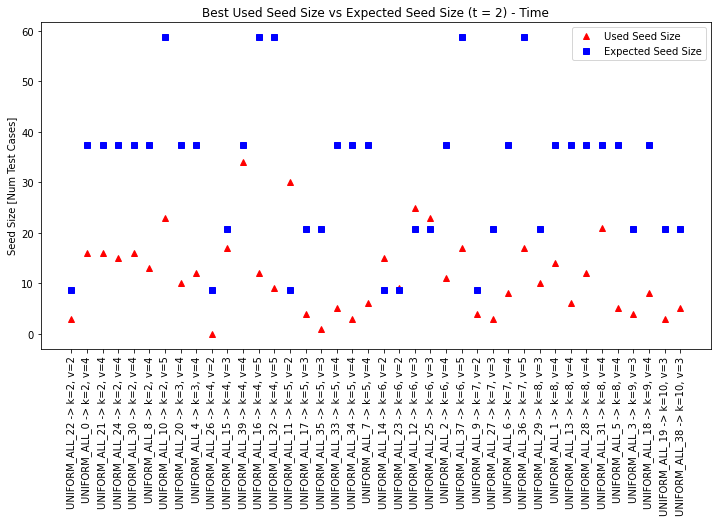

In [407]:
plot_data(2, expectedSizes, 'Time')

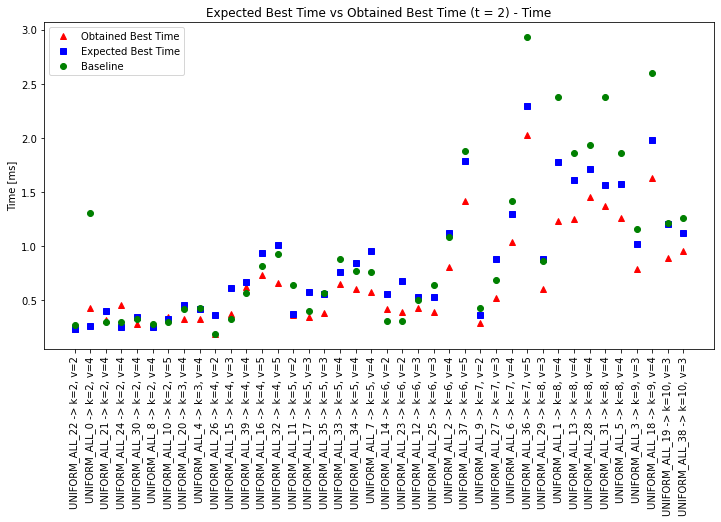

In [408]:
plot_expected_data_time(2, times, 'Time')

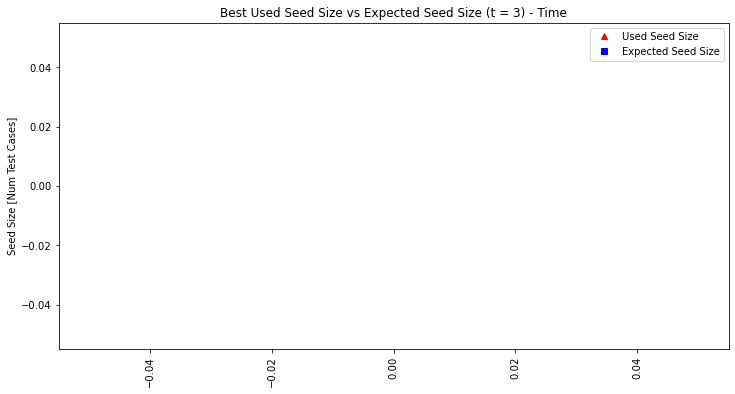

In [409]:
plot_data(3, expectedSizes, 'Time')

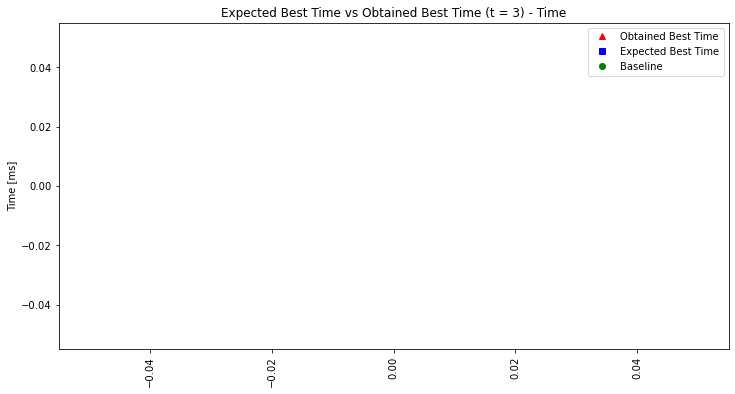

In [410]:
plot_expected_data_time(3, times, 'Time')

## Best Execution (*size*)

In [411]:
# New dataframe associating the model with the expected seed size
expectedSizes = pd.DataFrame(columns=['model', 'expectedSeedSize', 't', 'usedSeedSize', 'k', 'v'])

# For each model in FileName, extract the line with the best TSSize
for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        
        expectedSizes.loc[len(expectedSizes.index)] = [model,
                                                       math.log10( -(cInc * float(v) ** (-t))/(math.log10( 1 - float(v) ** (-t))) ) / math.log10( 1 - float(v) ** (-t)), 
                                                       t,
                                                       data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSSize']).head(1).iloc[0]['UsedSeedSize'],
                                                       k, 
                                                       v]
        
print(expectedSizes.shape)

(40, 6)


In [412]:
# First, order the data by k
expectedSizes = expectedSizes.sort_values(by=['k', 'v', 'model'])

In [413]:
sizes = pd.DataFrame(columns=['model', 'expctBestSize', 'obtainedBestSize', 't', 'k', 'baseline', 'v'])

# Extract the size obtained when using the "Used Seed Size" and that using the "Expected Seed Size"
for t in expectedSizes.t.unique():
    for model in expectedSizes.model.unique():         
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
                
        if (data[(data.t == t) &
                 (data.FileName == model) &
                 (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                 (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].empty): continue
          
        sizes.loc[len(sizes.index)] = [model,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['expectedSeedSize']))].iloc[0]['TSSize'],
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == math.floor(expectedSizes[(expectedSizes.t == t) &
                                                                                        (expectedSizes.model == model)].iloc[0]['usedSeedSize']))].iloc[0]['TSSize'],
                                       t,
                                       k,
                                       data[(data.t == t) &
                                                    (data.FileName == model) &
                                                    (data.SeedSize == 0)].iloc[0]['TSSize'],
                                       v]

print(sizes.shape)

(40, 7)


In [414]:
# First, order the data by k in ascending order
sizes = sizes.sort_values(by=['k', 'v', 'model'])

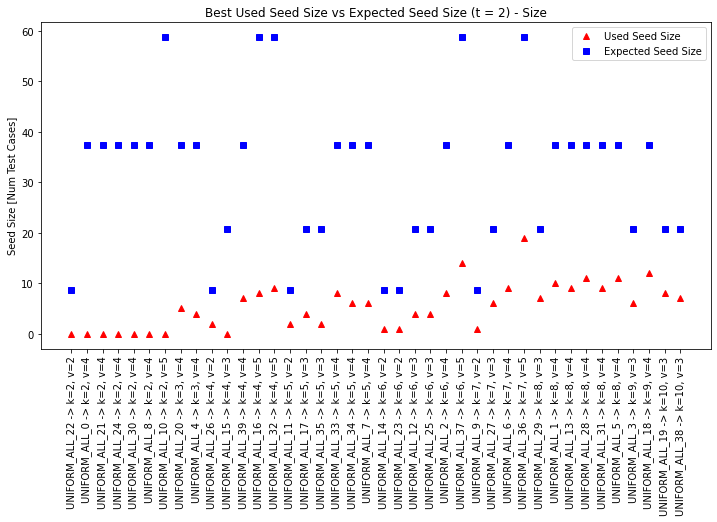

In [415]:
plot_data(2, expectedSizes, 'Size')

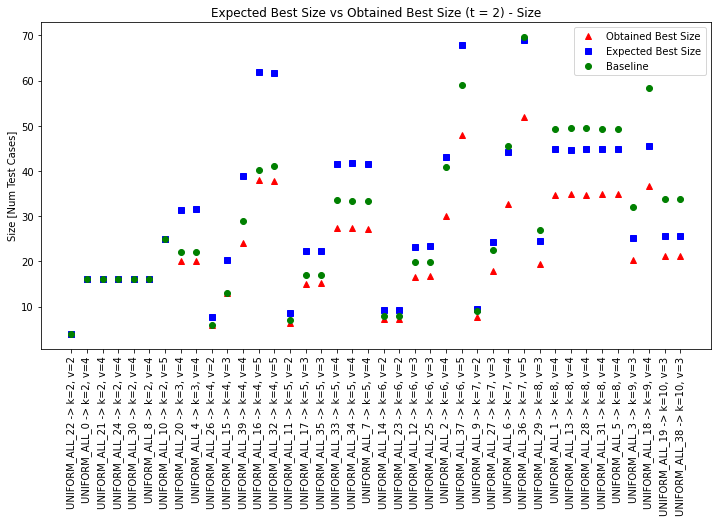

In [416]:
plot_expected_data_size(2, sizes, 'Size')

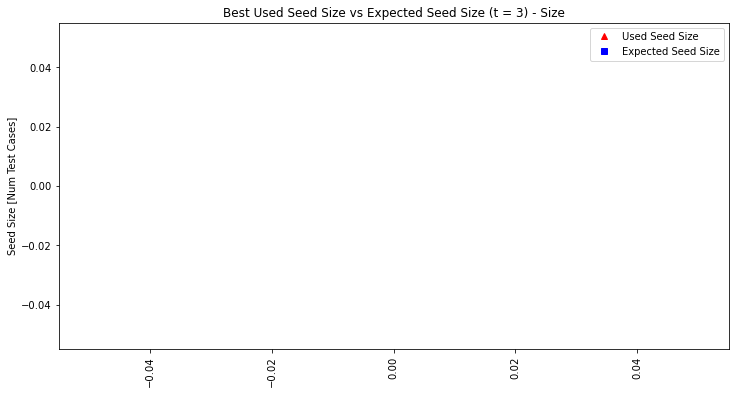

In [417]:
plot_data(3, expectedSizes, 'Size')

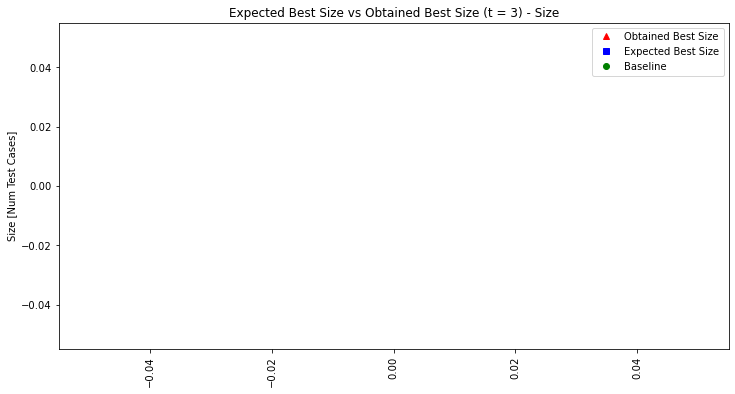

In [418]:
plot_expected_data_size(3, sizes, 'Size')

## Percentage of covered tuples by the random part in the best-case scenario (Size)

In [419]:
tuples = pd.DataFrame(columns=['model', 'covTuples', 't', 'k', 'v'])

for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        
        totTuples = data[(data.t == t) & (data.FileName == model)].iloc[0]['totTuples']
        
        tuples.loc[len(tuples.index)] = [model,
                                         (data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSSize']).head(1).iloc[0]['cRnd']  * data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSSize']).head(1).iloc[0]['UsedSeedSize']) / totTuples,
                                         t,
                                         k,
                                         v]
        
print(tuples.shape)

(40, 5)


In [420]:
# First, order the data by k in ascending order
tuples = tuples.sort_values(by=['k', 'v', 'model'])

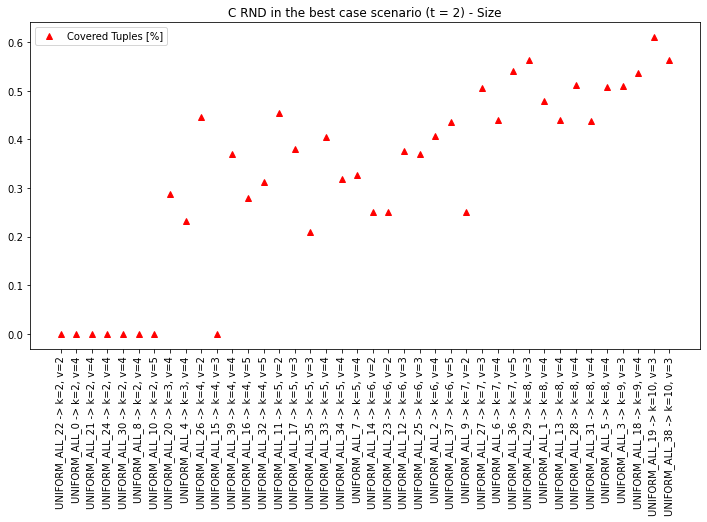

In [421]:
plot_coveredTuples(2, tuples, 'Size')

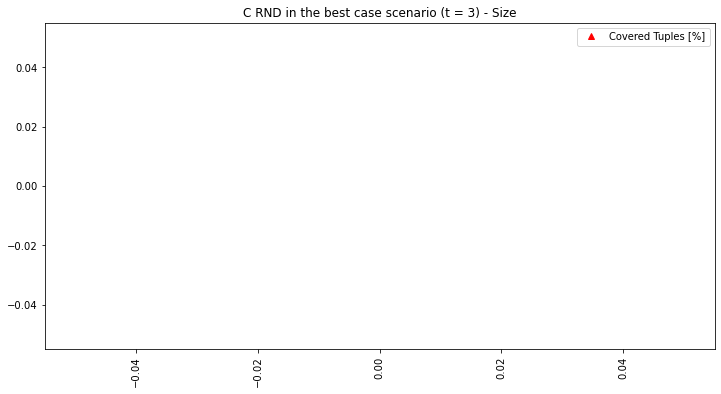

In [422]:
plot_coveredTuples(3, tuples, 'Size')

## Percentage of covered tuples by the random part in the best-case scenario (Time)

In [423]:
tuples = pd.DataFrame(columns=['model', 'covTuples', 't', 'k','v'])

for t in data.t.unique():
    for model in data.FileName.unique():
        if data[(data.t == t) & (data.FileName == model)].empty:
            continue
        
        k = data[(data.t == t) & (data.FileName == model)].iloc[0]['k']
        v = data[(data.t == t) & (data.FileName == model)].iloc[0]['v']
        
        totTuples = data[(data.t == t) & (data.FileName == model)].iloc[0]['totTuples']
        
        tuples.loc[len(tuples.index)] = [model,
                                         (data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSTime']).head(1).iloc[0]['cRnd']  * data[(data.t == t) & (data.FileName == model)].sort_values(by=['TSTime']).head(1).iloc[0]['UsedSeedSize']) / totTuples,
                                         t,
                                         k,
                                         v]
        
print (tuples.shape)

(40, 5)


In [424]:
# First, order the data by k in ascending order
tuples = tuples.sort_values(by=['k', 'v', 'model'])

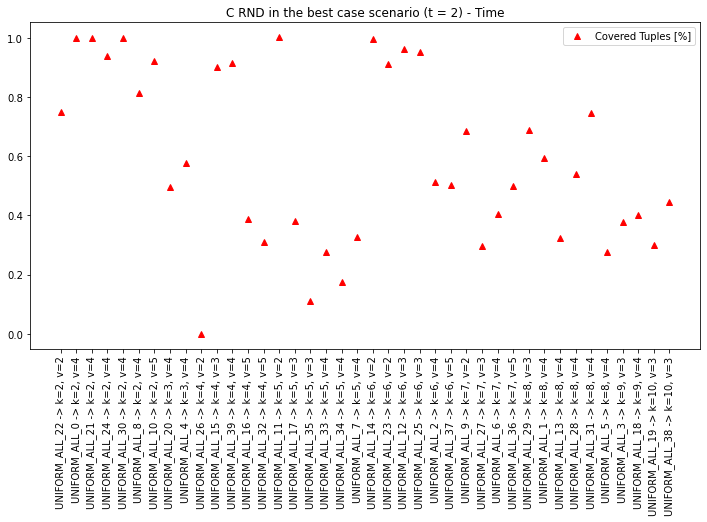

In [425]:
plot_coveredTuples(2, tuples, 'Time')

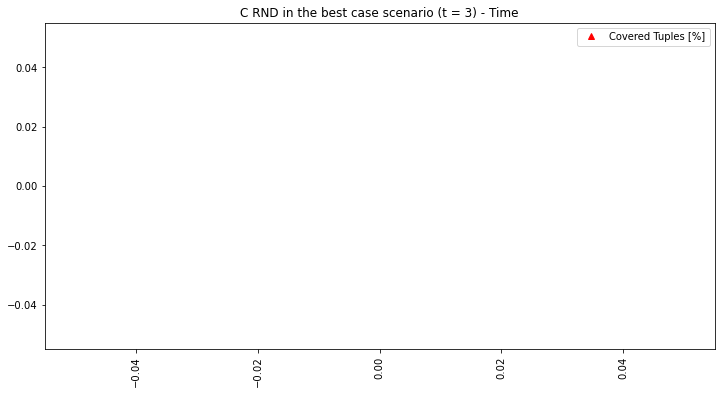

In [426]:
plot_coveredTuples(3, tuples, 'Time')